In [9]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from data_loader import load_and_process_data

plt.style.use('bmh')
%matplotlib inline

# Load Data (2010 - Present)
df = load_and_process_data('../data/BrentOilPrices.csv', start_date='2010-01-01')
prices = df['Price'].values
n_samples = len(prices)
days = np.arange(n_samples)

print(f"Data Loaded: {n_samples} days")

2026-02-11 23:05:31,932 - INFO - Loading data from ../data/BrentOilPrices.csv...
2026-02-11 23:05:31,939 - INFO - Parsing mixed date formats...
2026-02-11 23:05:32,231 - INFO - Data filtered: 9011 -> 3260 rows (Post-2010-01-01).


Data Loaded: 3260 days


### 1. Exploratory Data Analysis (EDA)
We perform stationarity testing and volatility analysis to justify the use of Change Point Detection.

Performing Augmented Dickey-Fuller Test...
ADF Statistic: -1.8272
p-value: 0.3671
>> Result: Time series is NON-STATIONARY (p > 0.05).
>> Implication: Mean and variance change over time, validating the need for Change Point Detection.


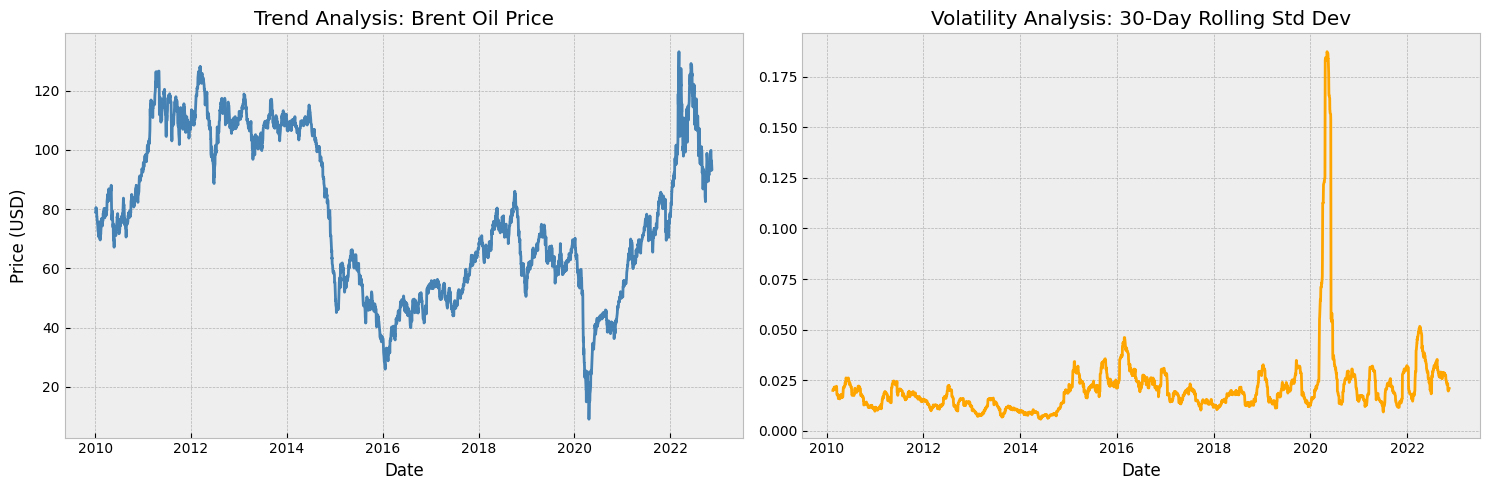

In [13]:
# --- Stationarity Test (ADF) ---
print(f"Performing Augmented Dickey-Fuller Test...")
result = adfuller(df['Price'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

if result[1] > 0.05:
    print(">> Result: Time series is NON-STATIONARY (p > 0.05).")
    print(">> Implication: Mean and variance change over time, validating the need for Change Point Detection.")
else:
    print(">> Result: Stationary.")

# --- Volatility Analysis (Log Returns) ---
df['Log_Ret'] = np.log(df['Price'] / df['Price'].shift(1))
df['Vol_30d'] = df['Log_Ret'].rolling(30).std()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df['Date'], df['Price'], c='steelblue')
plt.title("Trend Analysis: Brent Oil Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")

plt.subplot(1, 2, 2)
plt.plot(df['Date'], df['Vol_30d'], c='orange')
plt.title("Volatility Analysis: 30-Day Rolling Std Dev")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### 2. Bayesian Model Specification
We define a piece-wise constant model where the price $y_t$ is distributed normally:
$$ y_t \sim \text{Normal}(\mu_t, \sigma) $$

Where the mean $\mu_t$ switches value at timepoints $\tau_1$ and $\tau_2$:
- **Priors:**
  - $\mu \sim \text{Normal}([100, 50, 90], 20)$ (Informed by historical averages)
  - $\sigma \sim \text{HalfNormal}(10)$
  - $\tau \sim \text{DiscreteUniform}$ (Equal probability across time)
- **Algorithm:** NUTS (No-U-Turn Sampler)

In [15]:
print("Building 2-Change-Point Model...")

with pm.Model() as model_multi:
    # --- PRIORS ---
    # We expect 3 regimes (High -> Low -> Recovery)
    mu = pm.Normal('mu', mu=[100, 50, 90], sigma=20, shape=3)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # --- CHANGE POINTS (TAU) ---
    # Prior for the first change point (somewhere in the first 60% of data)
    tau1 = pm.DiscreteUniform('tau1', lower=0, upper=n_samples//2)
    # Prior for the second change point (somewhere after tau1)
    tau2 = pm.DiscreteUniform('tau2', lower=tau1 + 1, upper=n_samples - 1)
    
    # --- LIKELIHOOD ---
    idx = np.arange(n_samples)
    mean_val = pm.math.switch(idx < tau1, mu[0], 
                              pm.math.switch(idx < tau2, mu[1], mu[2]))
    
    likelihood = pm.Normal('likelihood', mu=mean_val, sigma=sigma, observed=prices)

print("Model built.")

Building 2-Change-Point Model...
Model built.


In [16]:
# Run Sampling
with model_multi:
    trace_multi = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9, random_seed=42)

Multiprocess sampling (2 chains in 2 jobs)
2026-02-11 23:13:47,237 - INFO - Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
2026-02-11 23:13:47,240 - INFO - CompoundStep
>NUTS: [mu, sigma]
2026-02-11 23:13:47,241 - INFO - >NUTS: [mu, sigma]
>CompoundStep
2026-02-11 23:13:47,244 - INFO - >CompoundStep
>>Metropolis: [tau1]
2026-02-11 23:13:47,245 - INFO - >>Metropolis: [tau1]
>>Metropolis: [tau2]
2026-02-11 23:13:47,246 - INFO - >>Metropolis: [tau2]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
2026-02-11 23:14:07,321 - INFO - Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
2026-02-11 23:14:07,383 - INFO - We recommend running at least 4 chains for robust computation of convergence diagnostics


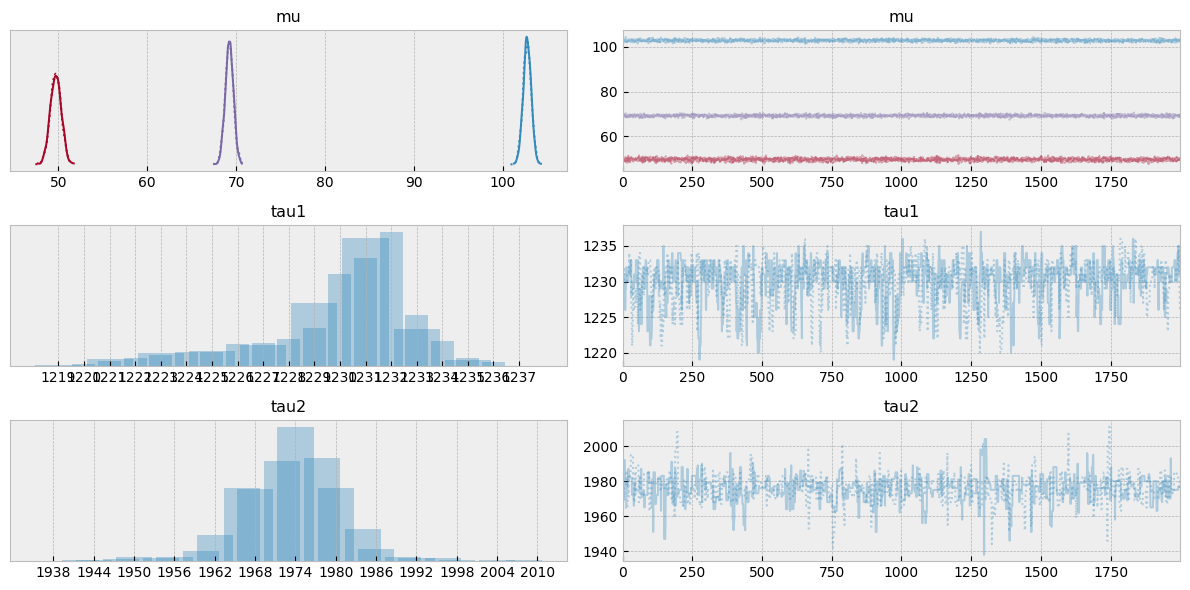

Regime 1 Mean: $102.71
Regime 2 Mean: $49.72 (Change: -51.59%)
Regime 3 Mean: $69.23 (Change: 39.23%)
Detected Change Point 1: 2014-11-25
Detected Change Point 2: 2017-10-25


In [17]:
# --- Results & Diagnostics ---
az.plot_trace(trace_multi, var_names=['mu', 'tau1', 'tau2'])
plt.tight_layout()
plt.savefig('../outputs/05_mcmc_trace_advanced.png') # Save for Report!
plt.show()

# Calculate Means and % Change
mu_vals = trace_multi.posterior['mu'].mean(dim=["chain", "draw"]).values
delta_1 = ((mu_vals[1] - mu_vals[0]) / mu_vals[0]) * 100
delta_2 = ((mu_vals[2] - mu_vals[1]) / mu_vals[1]) * 100

print(f"Regime 1 Mean: ${mu_vals[0]:.2f}")
print(f"Regime 2 Mean: ${mu_vals[1]:.2f} (Change: {delta_1:.2f}%)")
print(f"Regime 3 Mean: ${mu_vals[2]:.2f} (Change: {delta_2:.2f}%)")

# Extract Dates
tau1_mean = int(trace_multi.posterior['tau1'].mean())
tau2_mean = int(trace_multi.posterior['tau2'].mean())
date1 = df.iloc[tau1_mean]['Date'].date()
date2 = df.iloc[tau2_mean]['Date'].date()
print(f"Detected Change Point 1: {date1}")
print(f"Detected Change Point 2: {date2}")

Data exported for dashboard.


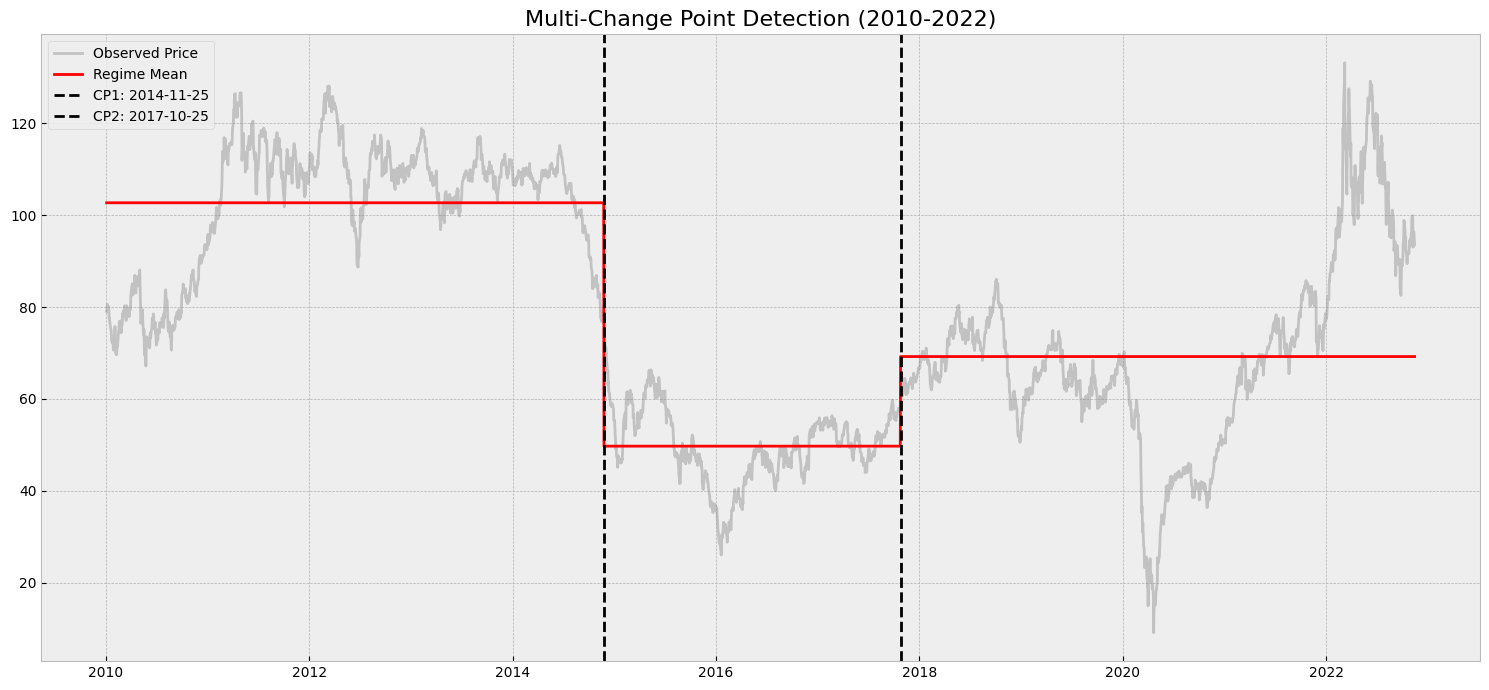

In [18]:
# Create dashboard data
dashboard_data = df.copy()
dashboard_data['Regime'] = 1
dashboard_data.loc[tau1_mean:tau2_mean, 'Regime'] = 2
dashboard_data.loc[tau2_mean:, 'Regime'] = 3
dashboard_data['Regime_Mean'] = dashboard_data['Regime'].map({1: mu_vals[0], 2: mu_vals[1], 3: mu_vals[2]})

dashboard_data.to_csv('../data/processed_dashboard_data.csv', index=False)
print("Data exported for dashboard.")

# Plot Final Result
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Price'], color='grey', alpha=0.4, label='Observed Price')
plt.plot(dashboard_data['Date'], dashboard_data['Regime_Mean'], color='red', lw=2, label='Regime Mean')
plt.axvline(df.iloc[tau1_mean]['Date'], color='k', ls='--', label=f'CP1: {date1}')
plt.axvline(df.iloc[tau2_mean]['Date'], color='k', ls='--', label=f'CP2: {date2}')
plt.title('Multi-Change Point Detection (2010-2022)', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/04_multi_changepoint.png')
plt.show()